# Hva om The Flash bruker en railgun til å akselere når han løper?
## Railgun tunnel

I denne oppgaven tar jeg konseptet av en railgun og anvender det for å se hvordan The Flash kan akselerere slik han gjør. Jeg skal se hvor mange lyn, som man ser oppstå når han løper, som må til for å akselerere han til ulike hastigheter.

Koden er skrevet som en funksjon railgun(length, diameter, mass, voltage), slik at jeg enkelt kan endre på over hvor lang "rullebane" han har på å akselerere, kroppstypen hans slik at jeg kan endre hvor mye han veier og hvordan han løper, og strømmen som går igjennom han når han akselererer. Funksjonen retunerer en akselerasjon-, hastighet-, posisjon- og tidsarray. Disse kan vi bruke til å studere hvordan bevegelsen hans er under akselerasjonen.

Først skal vi kun se hvordan endringer på variabler påvirker akselerasjonen hans. Deretter skal vi utvide modellen vår til å ta med indusert elektromagnetisk induksjon og luftmotstand. Når vi har gjort dette kan vi også se på hvor mye støm The Flash trenger for å opprettholde farten sin.

Underveis må vi gjøre en rekke antagelser for å kunne studere problemet vårt. I virkeligheten vil luften foran og bak The Flash skapt store problemer når vi beveger oss raskt. I tilleg er jo The Flash et menneske, med en litt mer komplisert komposisjon enn det vi modellerer han som. Mer om ulike faktorer som gjør problemstillingen vår vanskeligere å svare realistisk senere.

I serien av The Flash(2014-) når han en top hastighet av [$3.3mach$](https://the-take.com/watch/how-fast-can-the-flash-run). Det tilsvarer $1123m/s$, som vi setter som vårt mål.

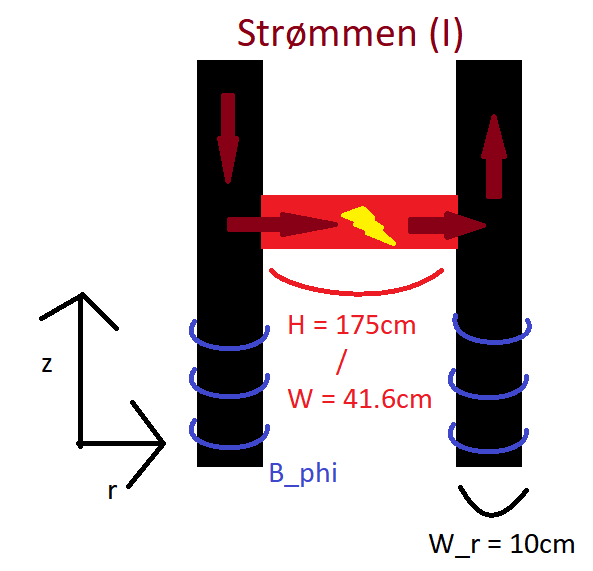

## Nødvendigheter for programmet vårt

Til å starte med importerer vi våre ulike biblioteker og bruker en kommando som gjør plottene enklere å bruke.

In [70]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from numba import jit

Vi bruker `numpy` til å beregne med,  og senere `matplotlib.pyplot` og `matplotlib.animation` til å plotte de ulike dataene våre.

De fleste olympiske sprinterne når top hastighet etter en lengde [$L=30$](https://www.espn.com/espn/feature/story/_/id/17277615/perfect-100-meters-how-run-olympics-fastest-event-right-way), så vi bruker dette som utgangspunkt. Videre har vi at et gjennomsnitlig lynnedslag består av [$V=30 000Amps$](https://www.weather.gov/safety/lightning-power). Så vi starter med kun et lyn, som en forenkling antar vi at et lyn slår konstant ned i The Flash. En gjennomsittlig amerikansk mann har en skulder bredde på [$W=41.6cm$](https://www.healthline.com/health/average-shoulder-width) og høyde på [$H=175cm$](https://en.wikipedia.org/wiki/Average_human_height_by_country). Vi vil se på ulike orienteringer av railgunnen vår, og trenger derfor begge to. Til slutt har vi at en sunn amerikansk mann har en [$bmi\approx 21.7$](https://www.healthline.com/health/mens-health/average-weight-for-men#weight-ranges), som tilsvarer for oss $M=66.5kg$. TIl slutt setter vi tidsteget $dt=1e-4$ ettersom vi har stor akselerasjon og dermed store endringer hvert sekund, og setter bredden på skinnene til [$w=10cm$](https://ndiastorage.blob.core.usgovcloudapi.net/ndia/2003/gun/ellis.pdf).

In [71]:
L = 30 #lengden det tar en sprinter å nå toppfart
I = 30000 #strømmen som går igjennom et gjennomsnittlig lyn
D = 0.416 #skulderbredden i meter
M = 66.5 #gjennomsnittlig vekt

dt = 0.0001 #tidsteg vi tar for hver iterasjon

w = 0.1 #bredden på skinnene i meter

Med starts parameterene våre definert må vi finne en funksjon for å finne kraften som virker fra railgunnen på The Flash.

---

## Vi finner et uttrykk for kraft

Allerede til å starte med trenger vi å gjøre en antagelse om lengden på skinnene må være. For vår forenklede modell antar vi at skinnene er uendelig lange, ettersom disse skinne er usynlige og et produkt av den magiske "speedforce" er ikke dette en helt dårlig antagelse. Når skinnene er uendelig lange vil funksjonen vår ikke lengre være avhengig av posisjon siden vi slipper å tenke på kanten av det magnetiske feltet til railgunnen.

Vi har fra Biot-Savartz lov:
\begin{equation}
    \oint_c \vec{B}\cdot \vec{dl} = \mu_0 I_s
\end{equation}
Vi velger en amper kurve $c$, som omfatter flaten $s$ hvor det går en strøm $I_s$ igjennom, med radius $r$ og sentrum midt mellom de to skinnene. På grunn av syllinder symmetri er $\vec{B}$ kun avhengig av radius $r$, integralet er ikke det og vi kan derfor sette den utenfor. Integrerer vi og løser for $B$ får vi:
\begin{equation}
    B = \frac{\mu_0}{2\pi} \frac{I_s}{r}
\end{equation}

Videre har vi fra Lorentz sin kraft lov at $\vec{dF} = Q\vec{v}\times\vec{B}$. Vi kan skrive $\vec{v}=\vec{\frac{dx}{dt}}$ og har at $I=\frac{dQ}{dt}$, trikser vi litt med disse ender vi opp med $\vec{dF}=\vec{dxI}\times\vec{B}$. Siden strømmen er null i alle andre retninger enn langs The Flash, som vist i Figuren over, kan vi skrive $\vec{dxI}=drI\hat{r}$, hvor $\hat{r}$ har lengde en og peker i radiell retning. Da får vi dette uttrykket for kraften $\vec{dF}$:
\begin{equation}
    \vec{dF}=\left|\begin{matrix} 
    \hat{r} & \hat{\phi} & \hat{z}\\
    Idr & 0 & 0 \\
    0 & B & 0
    \end{matrix}\right|
    =IdrB\hat{z}
\end{equation}
Som forventa blir The Flash dytta parallelt med skinnene. Vi har nå et uttrykk for en kraft $dF$ fra en av stavene fra strømmen $I$ igjennom et lite stykke av The Flash $dr$. Herifra og utover vil vi ignoerere vektor notasjon, ettersom de har samme retning. Videre må vi integrere over hele skulderbredden/høyden til The Flash. Vi kaller stedfordrederen til høyden $H$ og skulderbredden $W$ for $D$. Vi har da uttrykket:
\begin{equation}
    \int_{\frac{w}{2}}^{D+\frac{w}{2}}dF=\int_{\frac{w}{2}}^{D+\frac{w}{2}}IdrB=\frac{\mu_0}{2\pi}I^2\int_{\frac{w}{2}}^{D+\frac{w}{2}}\frac{1}{r} dr
\end{equation}
\begin{equation}
    F_{skinne}=\frac{\mu_0}{2\pi}I^2\left(ln(D+\frac{w}{2})-ln(\frac{w}{2})\right)
\end{equation}
Vi integrerer over lengden det går en strøm igjennom, vi har gjort en forenkling og sagt at all strømmen går midt i skinnene og tar en nitti grader sving og går inn i The Flash. Da blir lengden lik radiusen til to staver og lengden til The Flash. Videre må vi gange dette uttrykket med to, ettersom det er to staver som begge utøver den samme kraften med samme retning på grunn av symmetri. Som gir oss en total kraft:
\begin{equation}
    F_{tot}=2F_{skinne}=2\frac{\mu_0}{2\pi}I^2\left(ln(D+\frac{w}{2})-ln(\frac{w}{2})\right)
\end{equation}
For å gjøre ting enklere med kodingen definerer vi $\frac{\mu_0}{2\pi}$ nå:

In [72]:
muover2pi = 2e-7

---
## Vi simulerer akselerasjonen på The Flash

Med vårt første enkle uttrykk for kraften på The Flash kan vi gå videre til å lage funksjonen vår. 

Funksjonen vil retunere arrays med akselerasjon, hastighet, posisjon og tid. Vi bruker uttrykket over til å finne akselerasjon, som vi bruker til å oppdatere hastighet vært tidsteg $dt$, som igjen vil bli brukt til å oppdatere posisjon. For å gjøre dette vil vi bruke EulerCromer.

In [73]:
#Argumenter
#L : lengden av vår hypotiserte railgun
#D : skulderbredden til The Flash
#M : vekten til The Flash
#I : strømmen som går igjennom


@jit
def railgun(L, D, M, I):
    a = np.zeros(0)
    v = np.zeros(0)
    x = np.zeros(0)
    
    T = 0
    aold = 2*muover2pi * I**2 * (np.log(D + w/2) - np.log(w/2)) / M
    vold, xold = 0, 0
    while xold < L:
        anew = aold
        vnew = vold + aold*dt
        xnew = xold + vnew*dt
        a = np.append(a, anew)
        v = np.append(v, vnew)
        x = np.append(x, xnew)
        T += dt
        aold, vold, xold = anew, vnew, xnew
        
    t = np.linspace(0, T, len(a))
    return a, v, x, t

Vi kjører vår første test med variablene definert i starten

In [74]:
aTest1, vTest1, pTest1, tTest1 = railgun(L, D, M, I)
print(f"Den første testen, med skinnene på hver side av skulderne til The Flash, oppnår vi en maks fart av {vTest1[-1]:g}m/s")

Den første testen, med skinnene på hver side av skulderne til The Flash, oppnår vi en maks fart av 26.9265m/s


Text(0, 0.5, 'x[m]')

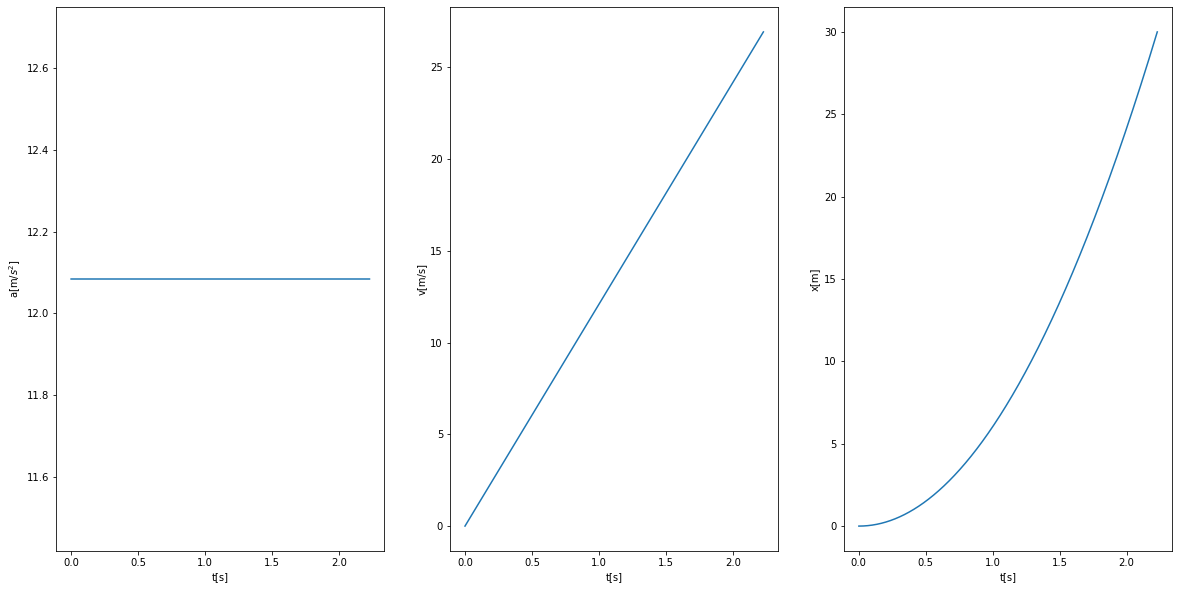

In [75]:
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.plot(tTest1, aTest1)
plt.xlabel("t[s]")
plt.ylabel("a[m/$s^2$]")
plt.subplot(1, 3, 2)
plt.plot(tTest1, vTest1)
plt.xlabel("t[s]")
plt.ylabel("v[m/s]")
plt.subplot(1, 3, 3)
plt.plot(tTest1, pTest1)
plt.xlabel("t[s]")
plt.ylabel("x[m]")

Som forventa er akselerasjonen konstant, hastigheten er en rett linje, og posisjon vokser eksponensielt. I tilleg fikk vi heller ikke noe særlig god fart. Dette er hovedsakelig et resultat av at The Flash er ganske tung og vi har lite strøm som går igjennom The Flash. Fra en tidligere [computational essay](https://uio-ccse.github.io/computational-essay-showroom/essays/exampleessays/railgun_TOO/Railgun_V1_9.html) krevde det nesten 800 tusen amp for å akselerere en 1kg pakke til omtrent $2$ $700m/s$ med $10m$ lange skinner. Så selv om vi har en litt større avstand mellom de to skinne er dette ikke nærheten av nok. Derfor starter vi med 900 tusen amp, og legger til et og et lyn for hver iterasjon, til vi når målet vårt om en mach.

In [79]:
I = 900000 #ny baseline for strøm
growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
current_velocity = start
a, v, x, t = [], [], [], []
while current_velocity < target:
    anew, vnew, xnew, tnew = railgun(L, D, M, I)
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    current_velocity = vnew[-1]
    I += growth
I -= growth #retter opp for det siste tidssteget
print(f"For å nå en hastighet {current_velocity:g}m/s, trenger The Flash en strøm I={I/1e6:g}MA. Det tilsvarer {int(I/growth)} lynnedslag i sekundet, og tok han {t[-1][-1]:g} sekunder")

For å nå en hastighet 1131.88m/s, trenger The Flash en strøm I=1.26MA. Det tilsvarer 42 lynnedslag i sekundet, og tok han 0.0531 sekunder


Vi ønsker å se hvordan dette varierer med vekt og lengden på rullebanen. Hva om vi isteden lar strømmen gå fra hode til tå? Først ser vi på hva som skjer om $D=1.75m$

In [8]:
D = 1.75 #ny orientering av skinnene

I = 900000 #ny baseline for strøm
growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
current_velocity = start
while current_velocity < target:
    anew, vnew, xnew, tnew = railgun(L, D, M, I)
    current_velocity = vnew[-1]
    I += growth
I -= growth #retter opp for det siste tidssteget
print(f"For å nå en hastighet {current_velocity:g}m/s med {D=}m, trenger The Flash en strøm I={I/1e6:g}MA. Det tilsvarer {int(I/growth)} lynnedslag konstant")

For å nå en hastighet 1126.02m/s med D=1.75m, trenger The Flash en strøm I=0.99MA. Det tilsvarer 33 lynnedslag konstant


Så om vi ønsker mest akselerasjon ønsker vi å ha skinnene over hodet og i bakken. Videre ser vi på resultater for hva som skjer for ulike vekter i intervallet $[M, 2M]kg$ og ulike lengder på rullebanen i intervallet $[1, 30]m$. Fra logikk kan vi hypotisere flere lynnedslag i sekundet som trengs for begge endringene, men vi er interesert i hvordan disse endringene oppfører seg. Vil det gå greit om The Flash legger på seg noen kiloer? Eller vil noen få kilo resultere i relativt enorme strøm krav i forhold til det vi allerede har sett. Og kan The Flash kunne klare å nå slike høye hastigheter på relativ korte avstander? Vi setter $D=0.416m$ igjen og se hva som skjer

In [9]:
D = 0.416 #ny orientering av skinnene

N = 10 
Mmin, Mmax = 66.5, 132 #masse intervallet
intM1 = np.linspace(Mmin, Mmax, N)

growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
a, v, x, t, Ilist1M = [], [], [], [], []
for M in intM1:
    I = 900000 #ny baseline for strøm
    current_velocity = start
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgun(L, D, M, I)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist1M.append(I)

Text(0, 0.5, 'Lyn[30kA]')

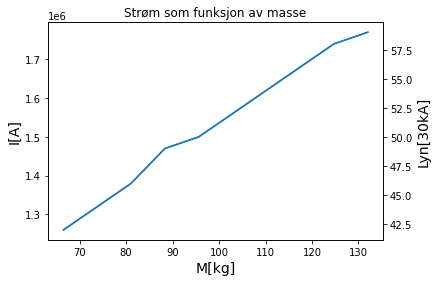

In [10]:
Ilist1M = np.array(Ilist1M)
fig,ax = plt.subplots()
ax.set_title("Strøm som funksjon av masse")
ax.plot(intM1, Ilist1M)
ax.set_xlabel("M[kg]",fontsize=14)
ax.set_ylabel("I[A]",fontsize=14)
ax2 = ax.twinx()
ax2.plot(intM1, Ilist1M/growth)
ax2.set_ylabel("Lyn[30kA]",fontsize=14)

Vi ser at det er en nesten lineær øking av strøm krav, med noen små avvik som trolig stammer fra avrundingfeil. Vi gjør det samme med lengde på rullebanen

In [11]:
D = 0.416 #ny orientering av skinnene

N = 30 
Lmin, Lmax = 1, 30 #rullebane intervallet
intL1 = np.linspace(Lmin, Lmax, N)

M = Mmin #resetter vekten på The Flash til det vi starta med

growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
a, v, x, t, Ilist1L= [], [], [], [], []
for L in intL1:
    I = 900000 #ny baseline for strøm
    current_velocity = start # resetter start hastigheten
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgun(L, D, M, I)
        a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist1L.append(I)

Text(0, 0.5, 'Lyn[30kA]')

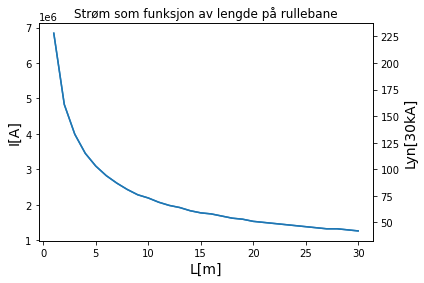

In [12]:
Ilist1L = np.array(Ilist1L)
fig,ax = plt.subplots()
ax.set_title("Strøm som funksjon av lengde på rullebane")
ax.plot(intL1, Ilist1L)
ax.set_xlabel("L[m]",fontsize=14)
ax.set_ylabel("I[A]",fontsize=14)
ax2=ax.twinx()
ax2.plot(intL1, Ilist1L/growth)
ax2.set_ylabel("Lyn[30kA]",fontsize=14)

Her ser vi et eksponsiel forfall. Desto kortere rullebane, og dermed kortere tid, desto mer strøm krever The Flash for å nå de samme hastighetene.

Så om The Flash legger seg på noen kilo vil det altså ikke være et like stort problem som om han bare har under 10 meter på å akselerere. Her ignorerer vi det at et lyn nedslag alene er nok til å drepe de fleste og ingen vil overleve 225 lyn som slår ned i deg konstant. Heldigvis har The Flash speedforce til å hjelpe han motstå alt dette.

---
## Vi introduserer en mer komplisert utvidet modell

Hittil har vi snakket om de mest idielle tilfellene, hvor vi ikke har tatt hensyn til luft motstand og indusert emf. Vi ønsker å se hva de samme testene forteller oss om vi implementerer dette i koden vår.

Først ser vi på luftmotstand. Siden dette er hovedsakelig en notebook om elektromagnetikk så hopper vi over utledingen av uttrykket:
\begin{equation}
    \vec{F_{luft}}=-\frac{1}{2}\rho_{luft}C_{msk.}A_{Flash} v\vec{v}
\end{equation}
Hvor [$\rho_{luft}C_{msk.}=0.36$](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/wea.29.02), [$A_{Flash}\approx1.8m^2$](https://www.calculator.net/body-surface-area-calculator.html?csex=m&bodyweight=66.5&bodyweightunit=kilogram&bodyheightfeet=5&bodyheightinch=9&bodyheight=175&x=0&y=0) og $v=|\vec{v}|$ er hastigheten til The Flash underveis. Siden kun front siden av the flash vil bidra til luftmotstand setter vi $A=\farc{1}{2}A_{Flash}$. Vi definerer $\rho_{luft}C_{msk.}=0.36$ med en gang.

In [13]:
rhoC = 0.36 #tetthet av luft ved overflaten ganger luftmotstand koeffisisenten for et menneske

Videre trenger vi et uttryk av den induserte strømmen. Denne vil virke også, som luftmotstand, som en demper på akselerasjonen og som et resultat kreve mer strøm fra lynene. Ved Faradays lov har vi at $emf=\frac{d\Phi_B}{dt}$, hvor $emf$ er indusert strøm og $\Phi_B$ er magnetisk fluks. Faradays lov gir oss også at denne fluksen kan skrives som:
\begin{equation}
    \Phi_B=\int_S \vec{B}\cdot\vec{dS}
\end{equation}
Hvor flaten S er gitt av kretsen hvor vi finner flatenormalen ved hjelp av høyrehåndregelen, som tilsvarer $dS\hat{n}=dS\hat{\phi}$. Vi integrerer på samme måte som vi fant uttrykket vårt for kraften på The Flash og ender opp med:
\begin{equation}
    \Phi_B=2\int_0^x\int_{w/2}^{D+w/2} \vec{B}\cdot\vec{dS}=2\int_0^x\int_{w/2}^{D+w/2}\frac{\mu}{2\pi}\frac{I}{r}drdx
\end{equation}
\begin{equation}
    \Phi_B=2\frac{\mu_0}{2\pi}I\left(ln(D+\frac{w}{2})-ln(\frac{w}{2})\right)x
\end{equation}
I følge Lenz lov vil denne induserte strømmen ha motsatt retning av retningen på strømmen.
\begin{equation}
    emf=\frac{d\Phi_B}{dt}=2\frac{\mu_0}{2\pi}I\left(ln(D+\frac{w}{2})-ln(\frac{w}{2})\right)\frac{dx}{dt}
\end{equation}
Siden posisjon $x$er det eneste som endrer seg med tid kan vi sette resten utenfor. Vi har også at $\frac{dx}{dt}=v$. Til slutt bruker vi Kirchoffs spenningslov gitt ved $\sum_i V_i=0$ til å finne at $-RI + emf = 0$. Setter vi resistansen i våre magiske skinner lik $R=1$ blir regningen videre lettere. Og vi står igjen med:
\begin{equation}
    I_{induced} = emf = -\frac{d\Phi_B}{dt}=2\frac{\mu_0}{2\pi}I\left(ln(D+\frac{w}{2})-ln(\frac{w}{2})\right)v
\end{equation}

Den nye funksjonen til vår oppdatere modell vil nå ta inn to ekstra argumenter $A$, overflate arealet til et menneske, og $F$, en funksjon for kraft som virker på The Flash.

Nå som vi enkelt kan sende inn funksjoner for kraften kan vi lage flere ulike uttrykk. I tilfelle The Flash ønsker å løpe opp noen vegger legger vi også muligheten for å ha med det. Som gir oss for nå to ulike uttrykk for kraft. Vi definerer de først. Den eneste begrensingen vi har nå er at de samme argumentene blir sendt inn til alle funksjonene, enten de brukes eller ikke. Om du ønsker å inkludere flere kilder til akselerasjon som krever andre variabler enn strøm $I$, avstand mellom skinner $D$, arealet til mennesket $A$, vekten $M$, farten $v$ og posisjonen $x$, vil du måtte ta hensyn til dette.

In [14]:
def forceNoGravity(I, D, A, M, v, x):
    I_induced = -2*muover2pi * I * (np.log(D + w/2) - np.log(w/2)) * v
    I = I + I_induced
    F_B = 2*muover2pi * I**2 * (np.log(D + w/2) - np.log(w/2))
    F_luft = -1/2*rhoC*A*v**2
    return F_B  + F_luft
    
def forceGravity(I, D, A, M, v, x):
    I_induced = -2*muover2pi * I * (np.log(D + w/2) - np.log(w/2)) * v
    I = I + I_induced
    F_B = 2*muover2pi * I**2 * (np.log(D + w/2) - np.log(w/2))
    F_luft = -1/2*rhoC*A*v**2
    F_g = -9.8*M #m/s^2
    return F_B + F_luft + F_g

Så må vi endre et par ting fra vår gamle railgun funksjon. Den må ta imot de nye argumentene og bruke den funksjonen sendt inn til å beregne akselerasjonen.

In [15]:
#Argumenter
#L : lengden av vår hypotiserte railgun
#D : skulderbredden til The Flash
#M : vekten til The Flash
#I : strømmen som går igjennom
#A : overflatearealet av et menneske
#F : en funksjon for kraft, tar argumentene (I, D, A, M, v, x)


@jit
def railgunUpdate(L, D, M, I, A, F):
    a = np.zeros(0)
    v = np.zeros(0)
    x = np.zeros(0)
    
    T = 0
    vold, xold = 0, 0
    aold = F(I, D, A, M, vold, xold) / M
    while xold < L:
        anew = F(I, D, A, M, vold, xold) / M
        vnew = vold + aold*dt
        xnew = xold + vnew*dt
        a = np.append(a, anew)
        v = np.append(v, vnew)
        x = np.append(x, xnew)
        T += dt
        aold, vold, xold = anew, vnew, xnew
        
    t = np.linspace(0, T, len(a))
    return a, v, x, t

Vi gjør det samme som for første modell og ser på hvordan $a$, $v$, $x$ og $I$ oppfører seg.

In [22]:
A = 1.81 / 2 #overflate arealet til delen av kroppen som blir truffet av vind
#setter alt tilbake til det vi starta med
L = 30 #lengden det tar en sprinter å nå toppfart
I = 30000 #strømmen som går igjennom et gjennomsnittlig lyn
D = 0.416 #skulderbredden i meter
M = 66.5 #gjennomsnittlig vekt

aTest2, vTest2, pTest2, tTest2 = railgunUpdate(L, D, M, I, A, forceNoGravity)
print(f"Den andre testen, med skinnene på hver side av skulderne til The Flash, oppnår vi en maks fart av {np.amax(vTest2):g}m/s,")
print(f"mens den første ga oss en fart på {vTest1[-1]:g}m/s")

Den andre testen, med skinnene på hver side av skulderne til The Flash, oppnår vi en maks fart av 25.9665m/s,
mens den første ga oss en fart på 26.9265m/s


Text(0, 0.5, 'x[m]')

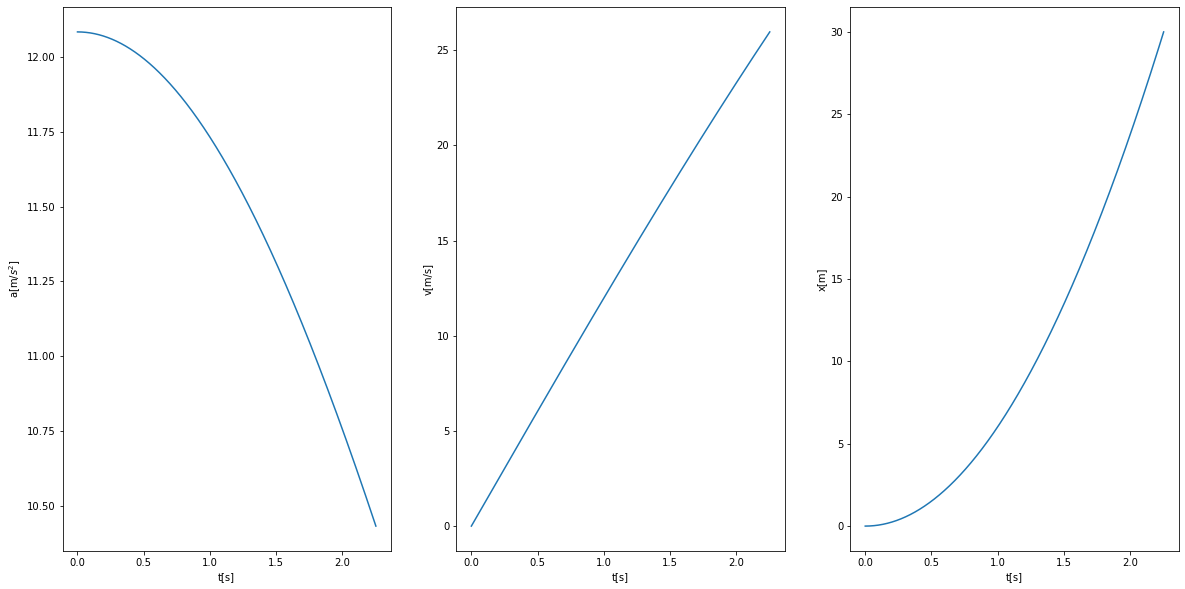

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.plot(tTest2, aTest2)
plt.xlabel("t[s]")
plt.ylabel("a[m/$s^2$]")
plt.subplot(1, 3, 2)
plt.plot(tTest2, vTest2)
plt.xlabel("t[s]")
plt.ylabel("v[m/s]")
plt.subplot(1, 3, 3)
plt.plot(tTest2, pTest2)
plt.xlabel("t[s]")
plt.ylabel("x[m]")

Vi ser en stor forskjell på grafen for akselerasjon, som tidligere var konstant. Forskjellen er ikke like tydelig på posisjon og fart grafen ettersom, om man ser på y-aksen til akselerasjonsplottet til venstre, akselerasjonen ikke endrer seg mye. Likevel vet vi at farten er påvirket ettersom vi nå ender opp med en mindre fart når vi kommer ut av railgunnen.

Videre så vi på hvor mye strøm som krevdes for å nå $3.3 mach$. Vi gjentar dette forsøket, men ser ikke på dersom $D=1.75m$ i tillegg.

In [18]:
I = 900000 #ny baseline for strøm
growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
current_velocity = start
a, v, x, t = [], [], [], []
while current_velocity < target:
    anew, vnew, xnew, tnew = railgunUpdate(L, D, M, I, A, forceNoGravity)
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    current_velocity = vnew[-1]
    I += growth
I -= growth #retter opp for det siste tidssteget
print(f"For å nå en hastighet {current_velocity:g}m/s, trenger The Flash en strøm I={I/1e6:g}MA. Det tilsvarer {int(I/growth)} lynnedslag i sekundet")

For å nå en hastighet 1142.51m/s, trenger The Flash en strøm I=1.32MA. Det tilsvarer 44 lynnedslag i sekundet


Her ser vi altså ikke en særlig stor endring, fra 42 til 44 lynnedslag tilsvarer en økning på omtrent $4.8\%$.

Vi ser hva som skjer om vi varierer på vekten og lengden på rulle banen igjen.

In [19]:
D = 0.416 #ny orientering av skinnene

N = 10 
Mmin, Mmax = 66.5, 132 #masse intervallet
intM2 = np.linspace(Mmin, Mmax, N)

growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
a, v, x, t, Ilist2M = [], [], [], [], []
for M in intM2:
    I = 900000 #ny baseline for strøm
    current_velocity = start
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgunUpdate(L, D, M, I, A, forceNoGravity)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist2M.append(I)

Text(0, 0.5, 'Lyn[30kA]')

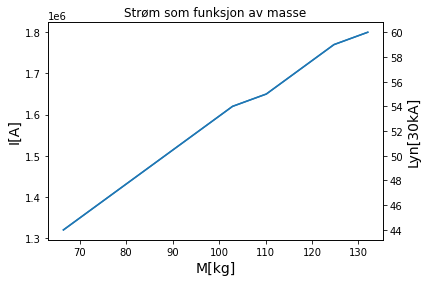

In [20]:
Ilist2M = np.array(Ilist2M)
fig,ax = plt.subplots()
ax.set_title("Strøm som funksjon av masse")
ax.plot(intM2, Ilist2M)
ax.set_xlabel("M[kg]",fontsize=14)
ax.set_ylabel("I[A]",fontsize=14)
ax2 = ax.twinx()
ax2.plot(intM2, Ilist2M/growth)
ax2.set_ylabel("Lyn[30kA]",fontsize=14)

In [24]:
D = 0.416 #ny orientering av skinnene

N = 30 
Lmin, Lmax = 1, 30 #rullebane intervallet
intL2 = np.linspace(Lmin, Lmax, N)

M = Mmin #resetter vekten på The Flash til det vi starta med

growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
a, v, x, t, Ilist2L= [], [], [], [], []
for L in intL2:
    I = 900000 #ny baseline for strøm
    current_velocity = start # resetter start hastigheten
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgunUpdate(L, D, M, I, A, forceNoGravity)
        a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist2L.append(I)

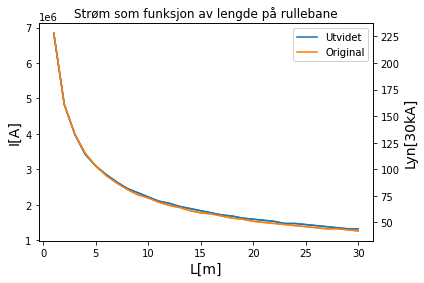

Text(0, 0.5, 'Lyn[30kA]')

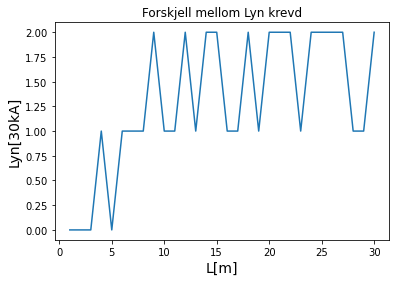

In [25]:
Ilist2L = np.array(Ilist2L)
fig,ax = plt.subplots()
ax.set_title("Strøm som funksjon av lengde på rullebane")
ax.plot(intL2, Ilist2L, label="Utvidet")
ax.plot(intL1, Ilist1L, label="Original")
ax.legend()
ax.set_xlabel("L[m]",fontsize=14)
ax.set_ylabel("I[A]",fontsize=14)
ax2=ax.twinx()
ax2.plot(intL2, Ilist2L/growth, label="Utvidet")
ax2.plot(intL1, Ilist1L/growth, label="Original")
ax2.legend()
ax2.set_ylabel("Lyn[30kA]",fontsize=14)
plt.show()
plt.title("Forskjell mellom Lyn krevd")
plt.plot(intL2, abs(Ilist2L-Ilist1L)/growth)
plt.xlabel("L[m]",fontsize=14)
plt.ylabel("Lyn[30kA]",fontsize=14)

Siden vi er begrenset til et helt lyn per iterasjon får vi ikke særlig stor nøyaktighet for forskjellen mellom de to, men det betyr også at den nye utvidet modellen vår har relativ lav påvirkninggrad. Akkurat nå ser det ut til å være en treng mot flere lyn som kreves desto lengre rullebanen er, dette vil jeg utforske videre. Så vi ser på intervallet $L=[1,100]$.

In [26]:
D = 0.416 #ny orientering av skinnene

N = 30 
Lmin, Lmax = 1, 100 #rullebane intervallet
intL3 = np.linspace(Lmin, Lmax, N)

M = Mmin #resetter vekten på The Flash til det vi starta med

growth = 30000 #verdien til et gjennomsnittlig lyn
target = 1122 #3.3 mach i m/s
start = 0
a, v, x, t, Ilist3L= [], [], [], [], []
a, v, x, t, Ilist4L= [], [], [], [], []
for L in intL3:
    I = 900000 #ny baseline for strøm
    current_velocity = start # resetter start hastigheten
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgun(L, D, M, I)
        a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist3L.append(I)
    #andre løkken
    I = 900000 #ny baseline for strøm
    current_velocity = start # resetter start hastigheten
    while current_velocity < target:
        anew, vnew, xnew, tnew = railgunUpdate(L, D, M, I, A, forceNoGravity)
        a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
        current_velocity = vnew[-1]
        I += growth
    I -= growth #retter opp for det siste tidssteget
    a.append(anew) ; v.append(vnew) ; x.append(xnew) ; t.append(tnew)
    Ilist4L.append(I)

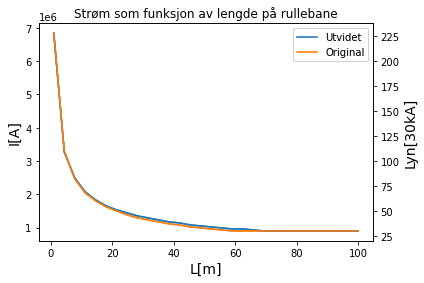

Text(0, 0.5, 'Lyn[30kA]')

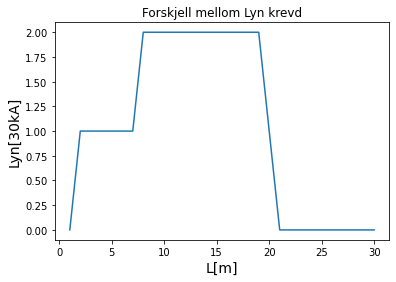

In [27]:
Ilist3L = np.array(Ilist3L)
Ilist4L = np.array(Ilist4L)
fig,ax = plt.subplots()
ax.set_title("Strøm som funksjon av lengde på rullebane")
ax.plot(intL3, Ilist4L, label="Utvidet")
ax.plot(intL3, Ilist3L, label="Original")
ax.legend()
ax.set_xlabel("L[m]",fontsize=14)
ax.set_ylabel("I[A]",fontsize=14)
ax2=ax.twinx()
ax2.plot(intL3, Ilist4L/growth, label="Utvidet")
ax2.plot(intL3, Ilist3L/growth, label="Original")
ax2.legend()
ax2.set_ylabel("Lyn[30kA]",fontsize=14)
plt.show()
plt.title("Forskjell mellom Lyn krevd")
plt.plot(intL2, abs(Ilist4L-Ilist3L)/growth)
plt.xlabel("L[m]",fontsize=14)
plt.ylabel("Lyn[30kA]",fontsize=14)

Det viser seg altså å ikke være en trend mot flere lyn som trengs desto lengre rulle bane.

---
## En siste utvidelse

Vi har nå fått en modell som tar hensyn til emf og luftmotstand. Så hva om vi ser videre på hvordan han løper over lengre avstander. Nå blir ikke målet lenger å nå en viss hastighet, men heller opprettholde denne hastigheten. Altså, hvor ofte må The Flash zappe seg selv med lyn for å kunne opprettholde slike hastigheter. Vi trenger ikke noe ny fysikk her, men heller finne betingelser for når han trenger strøm. 

Først ønsker vi å vite om et lyn er nok til å akselerere han, altså om det veier ut motkraften fra luftmotstand og emf. Om det altså ikke er en fartsøkning over et tidssteg ønsker vi å øke antall lyn med en. Med en gang vi når $3.3mach$ igjen ønsker vi å skru av stømmen. 

In [62]:
#Argumenter
#L : Hvor langt vi ønsker han å løpe
#D : skulderbredden til The Flash
#M : vekten til The Flash
#I : strømmen som går igjennom
#target : farten vi ønsker å opprettholde
#growth : Hvor mye strøm det er i et lyn
#A : overflatearealet av et menneske
#F : en funksjon for kraft, tar argumentene (I, D, A, M, v, x)


@jit
def railgunUpdateContinuous(L, D, M, I, target, growth, A, F):
    a = np.zeros(0)
    v = np.zeros(0)
    x = np.zeros(0)
    
    
    T = 0
    vold, xold = 0, 0
    aold = F(I, D, A, M, vold, xold) / M
    lynFrekvens = []
    while xold < L:
        anew = F(I, D, A, M, vold, xold) / M
        if vold > target:
            I = 0
        vnew = vold + aold*dt
        xnew = xold + vnew*dt
        a = np.append(a, anew)
        v = np.append(v, vnew)
        x = np.append(x, xnew)
        
        T += dt
        if vnew < vold:
            I += growth
        aold, vold, xold = anew, vnew, xnew
        lynFrekvens.append(I/growth)
        
    t = np.linspace(0, T, len(a))
    return a, v, x, t, lynFrekvens

Med den nye railgun funksjonen vår klar må vi bestemme oss for hvor langt vi ønsker han å løpe. Siden det tar $L=100m$ for å nå ønsket hastighet setter vi den nye lengdel lik $2L=200m$, dette burde være nok til å se et mønster danne seg. Vi setter verdier tilbake til det vi startet med i tilfelle de har blitt endra og setter strømmen vi starter med lik hva vi fant ut at vi trengte for å nå $3.3 mach$ på $100m$, som var $I=1.32MA=44lyn$

In [50]:
L = 200 #lengden det tar en sprinter å nå toppfart
D = 0.416 #skulderbredden i meter
M = 66.5 #gjennomsnittlig vekt
target = 1122 # 3.3mach i m/s
growth = 30000 #antall amp i et lynnedslag
A = 1.81 / 2 #overflate arealet til delen av kroppen som blir truffet av vind

w = 0.1 #bredden på skinnene i meter

In [60]:
I = 30000*44 #strømmen vi trenger for å nå 3.3 mach innen 100m
aTest3, vTest3, xTest3, tTest3, lynFrekvens = railgunUpdateContinuous(L, D, M, I, target, growth, A, forceNoGravity)

Text(0, 0.5, 'Lyn som intreffer[Lyn/dt]')

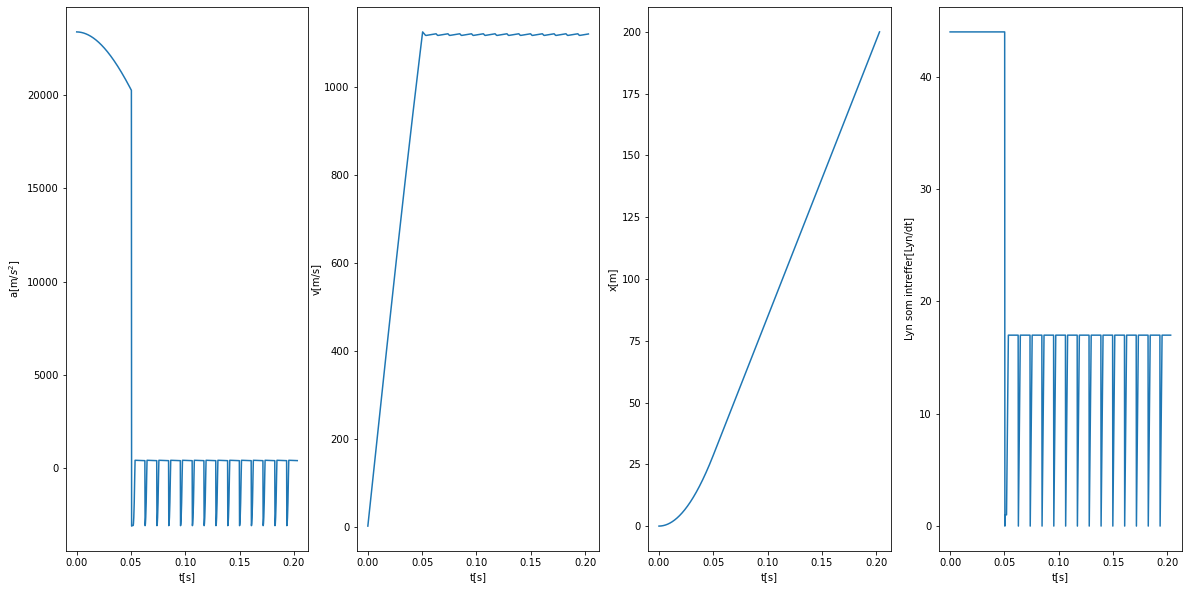

In [61]:
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.plot(tTest3, aTest3)
plt.xlabel("t[s]")
plt.ylabel("a[m/$s^2$]")
plt.subplot(1, 4, 2)
plt.plot(tTest3, vTest3)
plt.xlabel("t[s]")
plt.ylabel("v[m/s]")
plt.subplot(1, 4, 3)
plt.plot(tTest3, xTest3)
plt.xlabel("t[s]")
plt.ylabel("x[m]")
plt.subplot(1, 4, 4)
plt.plot(tTest3, lynFrekvens)
plt.xlabel("t[s]")
plt.ylabel("Lyn som intreffer[Lyn/dt]")

In [64]:
print(f"Det kreves {int(lynFrekvens[-1])} lyn for å kompansere for luftmotstanden ved hastigheter nær 3.3mach")

Det kreves 17 lyn for å kompansere for luftmotstanden ved hastigheter nær 3.3mach


Så nå har vi funnet ut hvordan akselerasjonen til The Flash oppfører seg ved en enkel modell, utvidet modell og over lengre avstander. Men underveis har vi gjort mange antagelser, noen litt verre enn andre, så det er viktig å se hvor realistisk dette er.

---
## Drøfting av hvor virkelighetsnær modellen vår er

Siden vi skriver om en mann som kan løpe raskere enn våre raskeste jagefly var ikke en realistisk modell et mål, men likevel er det mye nyttig informasjon vi kan få av å drøfte dette. 

En av de første antagelsene vi gjorde var at The Flash kunne lage denne railgunnen og påkalle lyn ved hjelp av speedforce. Dette lot oss forenkle en del ting. Siden skinnene bare kommer og går avhengig av viljen til The Flash kunne vi selv bestemme dimensjonene på skinnene, som inkludere å anse de som uendelig lange. Det lot oss ignorere z-komponenten på grunn av symmetri. Dette gjorde beregningene våre enklere uten noe kostnad på hvor realistisk det er i en verdenen med en supersonisk sprinter.

Det som er et litt større problem er alle lynene. Som nevnt ville et lyn være nok for å drepe de fleste, men på grunn av speed force sa vi at dette ikke var noe problem. Men om man tar hensyn til varmeutviklingen på omgivelsene får vi et problem. Vi har at energitap for en strøm igjennom en leder med resistans $R$ kan skrives som $\Delta P=I^2 R$. Innsiden av menneskekroppen har en resistans [$R=300\Omega$](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2763825/). Setter vi inn våre verdier får vi at det er et energitap på:
\begin{equation}
    \Delta P = (1.32\cdot10^6)^2\cdot300=5.2272\cdot10^{14}J/s
\end{equation}
Det tilsvarer omtrent 700 milliarder hestekrefter og på en 0.2 sekunder lang løpe tur vil han bruke $2.9\cdot10^8kWh=290GWh$ sog igjen tilsvarer omtrent [$0.1\%$](https://www.ssb.no/energi-og-industri/energi/statistikk/produksjon-og-forbruk-av-energi-energibalanse-og-energiregnskap) av Norges årlige strøm forbruk. Dette lover ikke godt. En slik varmeutvikling i luft vil være nok til å forutsake noen seriøse konsekvenser på lufta rundt The Flash.

Til slutt tar ikke denne modellen hensyn til at The Flash må ta raske svinger hele tida, som igjen krever mye akselerasjon. Så i realiteten vil gjennomsnittlig energi bruken være mye høyere enn det vi fant over.

Vi så også på hvordan energibehovet økte med høyere masse. Dette er relevant om The Flash ønsker å bære med seg noen ut av en brennende bygning. Så da får vi et annet problem også, som er hvordan kroppen deres skal tåle all strømmen igjennom de. Her må vi nok utvide vår tolkning av speedforce til å midlertidig omfatte den personen.

Til slutt må vi også tenke på at disse kreftene påvirker en person. De fleste mennesker kan tåle opp mot [$50m/s^2$](https://en.wikipedia.org/wiki/G-force#Human_tolerance), mens vi akselererer $1124m/s$ på omtrent en tjuenedel av et sekund. Så dette er ikke optimalt å gjenta.

Så hvorfor kan det være nyttig å drøfte slike ting? Dette er jo et ganske banalt eksempel for bruk av en railgun. Men jeg mener det gir oss et litt bedre inntrykk av problemene med en railgun og høy hastighetstransport. Vi ser foreksempel at for kun en person er energiforbruken svært høy. Selv om vi kunneløst dette noe ved å introdusere vakuum tuneller mellom skinnene vil energiforbruken gå ned litt, men som vi så var ikke økningen i nærheten av like stor som man kanskje skulle trodd. En vakuum tunnel ville fortsatt være nødvendig for å unngå eksplosjoner av luft som blir varmet opp ekstremt fort. Vi ser også at oppstarten har en ekstremt høy energikrav, enda det bare varer i en tyvende del av et sekund. Selv ikke oppretholdingen av farten er noe særlig enklere som vi fant ut av. Til slutt måtte også skinnene og materialet vi lager trasport modulen ut av også være svært god på å holde varme og mye lavere resistans enn en menneskekropp. Noe må også bli gjort med å fordele kreftene man vil oppleve under en slik akselerasjon. Dette er kun et fåtall av mulige problemer med en railgun i kommersiell bruk for transport som vi møtte på i vår analyse. Speedforce lot oss ignorere flere andre variabler som magnetkraften transport modulen ville ha på skinnene. De vil trolig ha blitt ødelagt på den første reisen. Mer om det [her](https://uio-ccse.github.io/computational-essay-showroom/essays/studentessays/railguncritique/RailgunCritique.html).

---
## Konklusjon, hva fant vi ut av akselerasjonen av The Flash

Vi fant ut at heller ikke en railgun kan bli brukt til å forklare hvordan The Flash akselererer og beveger seg så raskt. Gang på gang må vi trekke inn speedforce til å bortforklare hvorfor vi kan ignorere ting som varmeutvikling, strømkilde og egenskapene til skinnene. Videre fant vi ut at det blir betydelig mye vanskeligere for The Flash om han skulle redde noen på veien eller løpe sikksakk igjennom en bygning, ettersom energikravet øker eksponensielt med kortere avstander. Verdt å nevne her er at vi så på The Flash på sitt raskeste, som trolig ikke vil være tilfelle om han skulle bære noen eller løpe igjennom en bygning, men poenget står: Det er ikke noe realistisk. 

Likevel finner vi nyttig informasjon angående problemer med railgunns og transport. Det er ikke et komersielt alternativt når en brøkdels lang tur bruker en betydelig prosentandel av Norges årlige strømforbruk. Man kan heller ikke bruke millioner på å fikse skinnene for hver gang. Det hjelper heller ikke at passasjerene dør også under start fasen. Noen av disse problemene er enklere løst enn andre, men det får bli tatt opp i en annen artikkel.

## Kilder

 - https://the-take.com/watch/how-fast-can-the-flash-run
 - https://www.espn.com/espn/feature/story/_/id/17277615/perfect-100-meters-how-run-olympics-fastest-event-right-way
 - https://www.weather.gov/safety/lightning-power
 - https://www.healthline.com/health/average-shoulder-width
 - https://en.wikipedia.org/wiki/Average_human_height_by_country
 - https://www.healthline.com/health/mens-health/average-weight-for-men#weight-ranges
 - https://ndiastorage.blob.core.usgovcloudapi.net/ndia/2003/gun/ellis.pdf
 - https://uio-ccse.github.io/computational-essay-showroom/essays/exampleessays/railgun_TOO/Railgun_V1_9.html (koden er inspirert av)
 - https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/wea.29.02
 - https://www.calculator.net/body-surface-area-calculator.htmlcsex=m&bodyweight=66.5&bodyweightunit=kilogram&bodyheightfeet=5&bodyheightinch=9&bodyheight=175&x=0&y=0
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2763825/
 - https://www.ssb.no/energi-og-industri/energi/statistikk/produksjon-og-forbruk-av-energi-energibalanse-og-energiregnskap
 - https://en.wikipedia.org/wiki/G-force#Human_tolerance
 - https://uio-ccse.github.io/computational-essay-showroom/essays/studentessays/railguncritique/RailgunCritique.html
